<h1 style='font-family: Agency FB; font-size: 25px;  font-weight: 600''>1.0. Import Required Libraries</h1>

In [171]:
from scipy.stats import shapiro, levene, skew, kurtosis 
from scipy.stats import gaussian_kde
import scipy.stats as stats  

import matplotlib.pyplot as plt  
import seaborn as sns  
import pandas as pd  
import numpy as np 
import math
import re

import warnings  
warnings.simplefilter("ignore")  
pd.set_option('display.max_columns', 10) 
pd.set_option('display.float_format', lambda x: '%.2f' % x) 

<h1 style='font-family: Agency FB; font-size: 25px;  font-weight: 600''>2.0. Load and Inspect Dataset</h1>

In [217]:
DATA_PATH = "../Datasets/Marketing Campaign Dataset.csv"
full_data = pd.read_csv(DATA_PATH)
display(full_data)

,Store_ID,Date,Month Index,Store Size,Marketing Strategy,Average Order Values (Tsh),Post Campaign Period,Sales Revenue (Tsh)
0,1,2023-01-01,1,Small,Pilot Launch Regions,31398,0,1038101.58
1,1,2023-02-01,2,Small,Pilot Launch Regions,31398,0,859521.34
2,1,2023-03-01,3,Small,Pilot Launch Regions,31398,0,921424.44
3,1,2023-04-01,4,Small,Pilot Launch Regions,31398,0,899762.87
4,1,2023-05-01,5,Small,Pilot Launch Regions,31398,0,1072438.54
...,...,...,...,...,...,...,...,...
2995,100,2025-02-01,26,Medium,Business-as-Usual (BAU) Regions,37190,1,1594221.19
2996,100,2025-03-01,27,Medium,Business-as-Usual (BAU) Regions,37190,1,1330848.99
2997,100,2025-04-01,28,Medium,Business-as-Usual (BAU) Regions,37190,1,1535028.72
2998,100,2025-05-01,29,Medium,Business-as-Usual (BAU) Regions,37190,1,1601262.58


In [179]:
full_data['Date'] = pd.to_datetime(full_data['Date'])
event_date = full_data['Date'].min() + pd.DateOffset(months=18)
df = full_data[full_data['Date'] < event_date]
df

,Store_ID,Date,Month Index,Store Size,Marketing Strategy,Average Order Values (Tsh),Post Campaign Period,Sales Revenue (Tsh)
0,1,2023-01-01,1,Small,Pilot Launch Regions,31398,0,1038101.58
1,1,2023-02-01,2,Small,Pilot Launch Regions,31398,0,859521.34
2,1,2023-03-01,3,Small,Pilot Launch Regions,31398,0,921424.44
3,1,2023-04-01,4,Small,Pilot Launch Regions,31398,0,899762.87
4,1,2023-05-01,5,Small,Pilot Launch Regions,31398,0,1072438.54
...,...,...,...,...,...,...,...,...
2983,100,2024-02-01,14,Medium,Business-as-Usual (BAU) Regions,37190,0,1385822.26
2984,100,2024-03-01,15,Medium,Business-as-Usual (BAU) Regions,37190,0,1352717.41
2985,100,2024-04-01,16,Medium,Business-as-Usual (BAU) Regions,37190,0,1372174.06
2986,100,2024-05-01,17,Medium,Business-as-Usual (BAU) Regions,37190,0,1383435.11


<h1 style='font-family: Agency FB; font-size: 25px;  font-weight: 600''>3.0: Dataset Informartion Overviews</h1>

In [180]:
df.shape

(1800, 8)

In [181]:
for column in df.columns.tolist(): print(f"{'-'*15} {column}")

--------------- Store_ID
--------------- Date
--------------- Month Index
--------------- Store Size
--------------- Marketing Strategy
--------------- Average Order Values (Tsh)
--------------- Post Campaign Period
--------------- Sales Revenue (Tsh)


In [182]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1800 entries, 0 to 2987
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Store_ID                    1800 non-null   int64         
 1   Date                        1800 non-null   datetime64[ns]
 2   Month Index                 1800 non-null   int64         
 3   Store Size                  1800 non-null   object        
 4   Marketing Strategy          1800 non-null   object        
 5   Average Order Values (Tsh)  1800 non-null   int64         
 6   Post Campaign Period        1800 non-null   int64         
 7   Sales Revenue (Tsh)         1800 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 126.6+ KB


#### 3.2: Columns Profiling

In [183]:
def column_summary(df):
    summary_data = []
    for col_name in df.columns:
        col_dtype = df[col_name].dtype
        num_of_nulls = df[col_name].isnull().sum()
        num_of_non_nulls = df[col_name].notnull().sum()
        num_of_distinct_values = df[col_name].nunique()
        
        if num_of_distinct_values <= 10:
            distinct_values_counts = df[col_name].value_counts().to_dict()
        else:
            top_10_values_counts = df[col_name].value_counts().head(10).to_dict()
            distinct_values_counts = {k: v for k, v in sorted(top_10_values_counts.items(), key=lambda item: item[1], reverse=True)}

        summary_data.append({
            'col_name': col_name,
            'col_dtype': col_dtype,
            'num_of_nulls': num_of_nulls,
            'num_of_non_nulls': num_of_non_nulls,
            'num_of_distinct_values': num_of_distinct_values,
            'distinct_values_counts': distinct_values_counts
        })
    
    summary_df = pd.DataFrame(summary_data)
    return summary_df

summary_df = column_summary(df)
display(summary_df)

,col_name,col_dtype,num_of_nulls,num_of_non_nulls,num_of_distinct_values,distinct_values_counts
0,Store_ID,int64,0,1800,100,"{1: 18, 2: 18, 3: 18, 4: 18, 5: 18, 6: 18, 7: ..."
1,Date,datetime64[ns],0,1800,18,"{2023-01-01 00:00:00: 100, 2023-02-01 00:00:00..."
2,Month Index,int64,0,1800,18,"{1: 100, 2: 100, 3: 100, 4: 100, 5: 100, 6: 10..."
3,Store Size,object,0,1800,3,"{'Medium': 828, 'Small': 738, 'Large': 234}"
4,Marketing Strategy,object,0,1800,2,"{'Pilot Launch Regions': 900, 'Business-as-Usu..."
5,Average Order Values (Tsh),int64,0,1800,100,"{31398: 18, 33650: 18, 34282: 18, 38085: 18, 4..."
6,Post Campaign Period,int64,0,1800,1,{0: 1800}
7,Sales Revenue (Tsh),float64,0,1800,1800,"{1038101.58315586: 1, 859521.3395214358: 1, 92..."


#### 3.3: Exploring Invalid Entries Dtypes

In [184]:
def simplify_dtype(dtype):
    if dtype in (int, float, np.number): return 'Numeric'
    elif np.issubdtype(dtype, np.datetime64): return 'Datetime'
    elif dtype == str: return 'String'
    elif dtype == type(None): return 'Missing'
    else: return 'Other'

def analyze_column_dtypes(df):
    all_dtypes = {'Numeric', 'Datetime', 'String', 'Missing', 'Other'}
    results = pd.DataFrame(index=df.columns, columns=list(all_dtypes), dtype=object).fillna('-')
    
    for column in df.columns:
        dtypes = df[column].apply(lambda x: simplify_dtype(type(x))).value_counts()
        percentages = (dtypes / len(df)) * 100
        for dtype, percent in percentages.items():
            if percent > 0:
                results.at[column, dtype] = f'{percent:.2f}%'
            else:
                results.at[column, dtype] = '-'
    return results

results = analyze_column_dtypes(df)
display(results)

,Missing,Other,Numeric,String,Datetime
Store_ID,-,-,100.00%,-,-
Date,-,100.00%,-,-,-
Month Index,-,-,100.00%,-,-
Store Size,-,-,-,100.00%,-
Marketing Strategy,-,-,-,100.00%,-
Average Order Values (Tsh),-,-,100.00%,-,-
Post Campaign Period,-,-,100.00%,-,-
Sales Revenue (Tsh),-,-,100.00%,-,-


#### 3.4: Handling Duplicates Values

In [185]:
def handling_duplicates(df):
    Duplicates = df.duplicated().sum()
    if Duplicates != 0:
        df.drop_duplicates(inplace=True)
        return 
        print(f'Dataset has {Duplicates} Duplicates and values was cleaned successifully')
    else:
        print('Dataset has no Duplictes values')
handling_duplicates(df)

Dataset has no Duplictes values


#### 3.5: Checking Missing Values

In [186]:
def Missig_values_info(df):   
    isna_df = df.isna().sum().reset_index(name='Missing Values Counts')
    isna_df['Proportions (%)'] = isna_df['Missing Values Counts']/len(df)*100
    return isna_df
    
isna_df = Missig_values_info(df)
isna_df

,index,Missing Values Counts,Proportions (%)
0,Store_ID,0,0.00
1,Date,0,0.00
2,Month Index,0,0.00
3,Store Size,0,0.00
4,Marketing Strategy,0,0.00
5,Average Order Values (Tsh),0,0.00
6,Post Campaign Period,0,0.00
7,Sales Revenue (Tsh),0,0.00


<h1 style='font-family: Agency FB; font-size: 25px;  font-weight: 600''>4.0: Statistic Description of The Datasets</h1>

Let's take a moment to quickly explore some essential statistics of our dataset. By using the **`describe()`** function in pandas, we can generate a summary of key metrics for each numerical column in the dataset. This gives us a bird's-eye view of the data, helping us understand the general distribution and characteristics of the values.

In [187]:
summary_statics = df.describe().T.reset_index(names='Variable')
summary_statics

,Variable,count,mean,min,25%,50%,75%,max,std
0,Store_ID,1800.00,50.50,1.00,25.75,50.50,75.25,100.00,28.87
1,Date,1800,2023-09-15 22:40:00.000000256,2023-01-01 00:00:00,2023-05-01 00:00:00,2023-09-16 00:00:00,2024-02-01 00:00:00,2024-06-01 00:00:00,NaN
2,Month Index,1800.00,9.50,1.00,5.00,9.50,14.00,18.00,5.19
3,Average Order Values (Tsh),1800.00,34811.82,23409.00,31522.50,34862.00,38046.75,50305.00,5012.31
4,Post Campaign Period,1800.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,Sales Revenue (Tsh),1800.00,1212941.50,684232.21,1017966.87,1206293.21,1352735.33,1933746.66,240613.55


<h4 style='font-family: Agency FB; font-size: 18px;  font-weight: 600'>4.1: Continuous Variables Summary Statics</h4>


In [188]:
def summary_statistics(df, Variables: list=None, group_col: str=None):
    if Variables is None:
        Variables = df.select_dtypes(include=['number']).columns.tolist()
        if group_col in Variables:
            Variables.remove(group_col)

    
    results = []
    if group_col: grouped = df.groupby(group_col)
    else: grouped = [(None, df)]

    for group_name, group_df in grouped:
        for col in Variables:
            mean = group_df[col].mean()
            median = group_df[col].median()
            mode = group_df[col].mode().iloc[0] if not group_df[col].mode().empty else np.nan
            std_dev = group_df[col].std()
            variance = group_df[col].var()
            value_range = group_df[col].max() - group_df[col].min()
            skewness_val = skew(group_df[col], nan_policy='omit')  # Skewness
            kurtosis_val = kurtosis(group_df[col], nan_policy='omit')  # Kurtosis
    
            results.append({
                f'{group_col}': group_name,
                'Parameter': col,
                'Mean': mean,
                'Median': median,
                'Mode': mode,
                'Std. Deviation': std_dev,
                'Variance': variance,
                'Range': value_range,
                'Skewness': skewness_val,
                'Kurtosis': kurtosis_val
            })
    
        
    results = pd.DataFrame(results)
    if group_col == None: results = results.drop(columns=[f'{group_col}'])
    return results

In [189]:
results = summary_statistics(df)
display(results)

,Parameter,Mean,Median,Mode,Std. Deviation,Variance,Range,Skewness,Kurtosis
0,Store_ID,50.50,50.50,1.00,28.87,833.71,99.00,0.00,-1.20
1,Month Index,9.50,9.50,1.00,5.19,26.93,17.00,0.00,-1.21
2,Average Order Values (Tsh),34811.82,34862.00,23409.00,5012.31,25123280.33,26896.00,0.23,0.37
3,Post Campaign Period,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN
4,Sales Revenue (Tsh),1212941.50,1206293.21,684232.21,240613.55,57894879689.44,1249514.45,0.49,-0.29


<h4 style='font-family: Agency FB; font-size: 18px;  font-weight: 600'>4.2: Grouped Summary Statics I</h4>


In [190]:
results = summary_statistics(df, group_col='Marketing Strategy')
display(results)

,Marketing Strategy,Parameter,Mean,Median,Mode,Std. Deviation,Variance,Range,Skewness,Kurtosis
0,Business-as-Usual (BAU) Regions,Store_ID,54.70,57.50,2.00,28.39,806.15,98.00,-0.21,-0.99
1,Business-as-Usual (BAU) Regions,Month Index,9.50,9.50,1.00,5.19,26.95,17.00,0.00,-1.21
2,Business-as-Usual (BAU) Regions,Average Order Values (Tsh),35844.86,35274.50,23409.00,5358.10,28709253.45,26896.00,0.24,0.67
3,Business-as-Usual (BAU) Regions,Post Campaign Period,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN
4,Business-as-Usual (BAU) Regions,Sales Revenue (Tsh),1197874.74,1206066.99,735194.90,217639.33,47366876654.28,1189940.95,0.43,0.01
5,Pilot Launch Regions,Store_ID,46.30,42.00,1.00,28.76,826.89,96.00,0.21,-1.26
6,Pilot Launch Regions,Month Index,9.50,9.50,1.00,5.19,26.95,17.00,0.00,-1.21
7,Pilot Launch Regions,Average Order Values (Tsh),33778.78,33918.00,25318.00,4407.78,19428535.59,15926.00,-0.10,-1.03
8,Pilot Launch Regions,Post Campaign Period,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN
9,Pilot Launch Regions,Sales Revenue (Tsh),1228008.25,1206419.63,684232.21,260830.91,68032762887.97,1249514.45,0.47,-0.62


In [191]:
results = summary_statistics(df, group_col='Store Size')
display(results)

,Store Size,Parameter,Mean,Median,Mode,Std. Deviation,Variance,Range,Skewness,Kurtosis
0,Large,Store_ID,43.69,39.00,5.00,30.01,900.68,91.00,0.32,-1.15
1,Large,Month Index,9.50,9.50,1.00,5.20,27.03,17.00,0.00,-1.21
2,Large,Average Order Values (Tsh),34185.08,31246.00,25327.00,5406.71,29232535.59,15917.00,0.00,-1.56
3,Large,Post Campaign Period,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN
4,Large,Sales Revenue (Tsh),1656752.54,1651371.72,1401924.79,96179.26,9250450538.81,531821.88,0.08,-0.04
5,Medium,Store_ID,50.57,48.50,2.00,30.79,948.26,98.00,0.01,-1.37
6,Medium,Month Index,9.50,9.50,1.00,5.19,26.95,17.00,0.00,-1.21
7,Medium,Average Order Values (Tsh),34927.28,35673.50,23409.00,5299.50,28084674.41,26896.00,0.06,0.50
8,Medium,Post Campaign Period,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN
9,Medium,Sales Revenue (Tsh),1285648.77,1281427.74,994179.73,96909.72,9391493321.75,556322.05,-0.05,-0.20


<h4 style='font-family: Agency FB; font-size: 18px;  font-weight: 600'>4.3: Grouped Summary Statics II</h4>

In [192]:
def grpouped_summary_statistics(df: pd.DataFrame, group: str, variables: list= None,):
    if variables is None:
        variables = df.select_dtypes(include=['number']).columns.tolist()
        if group in variables:
            variables.remove(group)

    
    df2 = df.drop(columns=[group])
    grand_mean = df2[variables].mean()
    sem = df2[variables].sem()
    cv = df2[variables].std() / df2[variables].mean() * 100
    grouped = df.groupby(group)[variables].agg(['mean', 'sem']).reset_index()
    
    summary_df = pd.DataFrame()
    for variable in variables:
        summary_df[variable] = grouped.apply(
            lambda x: f"{x[(variable, 'mean')]:.2f} ± {x[(variable, 'sem')]:.2f}", axis=1
        )
    
    summary_df.insert(0, group, grouped[group])
    grand_mean_row = ['Grand Mean'] + grand_mean.tolist()
    sem_row = ['SEM'] + sem.tolist()
    cv_row = ['%CV'] + cv.tolist()
    
    summary_df.loc[len(summary_df)] = grand_mean_row
    summary_df.loc[len(summary_df)] = sem_row
    summary_df.loc[len(summary_df)] = cv_row
    
    return summary_df

results = grpouped_summary_statistics(df, group='Marketing Strategy')
results

,Marketing Strategy,Store_ID,Month Index,Average Order Values (Tsh),Post Campaign Period,Sales Revenue (Tsh)
0,Business-as-Usual (BAU) Regions,54.70 ± 0.95,9.50 ± 0.17,35844.86 ± 178.60,0.00 ± 0.00,1197874.74 ± 7254.64
1,Pilot Launch Regions,46.30 ± 0.96,9.50 ± 0.17,33778.78 ± 146.93,0.00 ± 0.00,1228008.25 ± 8694.36
2,Grand Mean,50.50,9.50,34811.82,0.00,1212941.50
3,SEM,0.68,0.12,118.14,0.00,5671.32
4,%CV,57.18,54.63,14.40,NaN,19.84


In [193]:
results = grpouped_summary_statistics(df, group='Store Size')
results

,Store Size,Store_ID,Month Index,Average Order Values (Tsh),Post Campaign Period,Sales Revenue (Tsh)
0,Large,43.69 ± 1.96,9.50 ± 0.34,34185.08 ± 353.45,0.00 ± 0.00,1656752.54 ± 6287.44
1,Medium,50.57 ± 1.07,9.50 ± 0.18,34927.28 ± 184.17,0.00 ± 0.00,1285648.77 ± 3367.85
2,Small,52.59 ± 0.95,9.50 ± 0.19,34881.00 ± 166.36,0.00 ± 0.00,990646.90 ± 3662.25
3,Grand Mean,50.50,9.50,34811.82,0.00,1212941.50
4,SEM,0.68,0.12,118.14,0.00,5671.32
5,%CV,57.18,54.63,14.40,NaN,19.84


<H1 style='font-family: Agency FB; font-size: 25px; font-weight: 600'>5.0: Visualize Group Differences</H1>

To gain more intuitive insights, let's explore the data distribution through visualizations. Visual tools like histograms, box plots, and scatter plots help us easily identify patterns, trends, and outliers in the data. These visuals provide a clear representation of how data is spread across variables, allowing for quicker interpretation and a deeper understanding of the dataset’s structure and relationships.

<h4 style='font-family: Agency FB; font-size: 18px; font-weight: 600'>5.1:  Histograms | Frequency Distribution</h4>

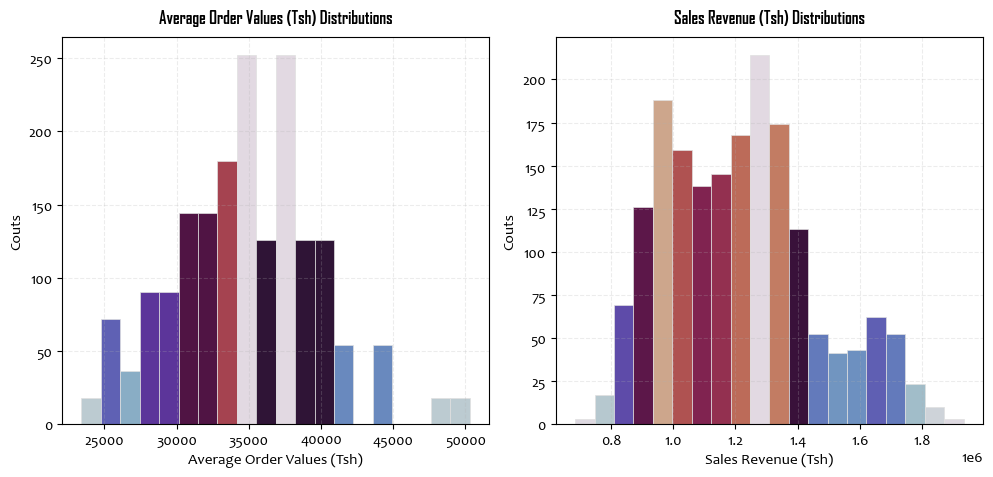

In [194]:
def multi_hitograms(data, Variables):
    num_variables = len(Variables)
    rows = math.ceil(num_variables / 3)
    cols = min(num_variables, 2)
    
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5* rows))
    plt.rcParams.update({'font.family': 'Sans-Serif', 'font.style': 'normal', 'font.size': 9})
    axes = axes.flatten() if num_variables > 1 else [axes]
    
    for idx, column in enumerate(Variables):
        n, bins, patches = axes[idx].hist(data[column], bins=20, edgecolor='#e0e0e0', linewidth=0.5, alpha=1)
        for i in range(len(patches)): patches[i].set_facecolor(plt.cm.twilight(n[i] / max(n)))
        axes[idx].set_title(f"{column} Distributions", fontsize=12, pad=10, fontweight='bold', fontfamily='Agency FB')
        axes[idx].grid(linestyle='--', alpha=0.23)
        axes[idx].set_xlabel(column)
        axes[idx].set_ylabel('Couts')
        
    
    for idx in range(num_variables, len(axes)): fig.delaxes(axes[idx])
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
    return fig

Variables = numerical_columns = ["Average Order Values (Tsh)", "Sales Revenue (Tsh)"]
Histograms = multi_hitograms(df, Variables)

<h4 style='font-family: Agency FB;  font-size: 18px; font-weight: 600'>5.2:  Kernel Density Estimation (KDE) plots</h4>

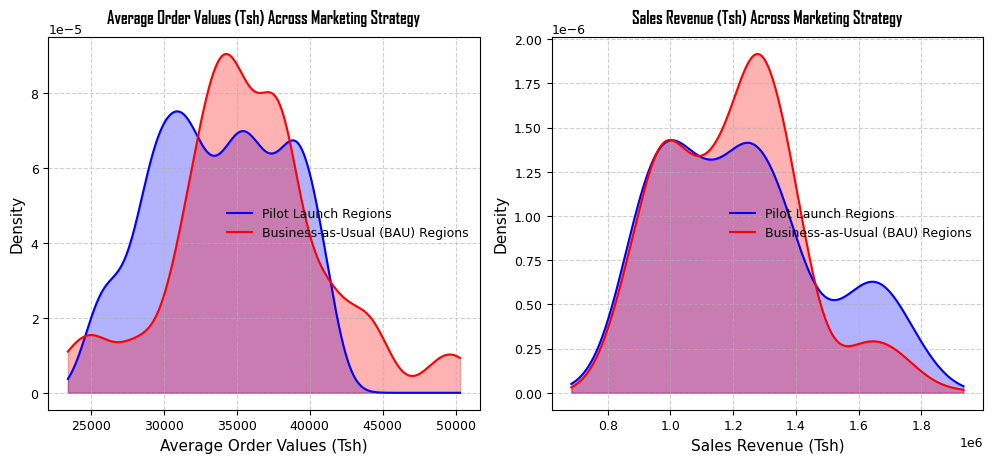

In [195]:
from scipy.stats import gaussian_kde

def multiple_kdeplots(df: pd.DataFrame, Variables: list, group_col: str=None):
    num_variables = len(Variables)
    rows = math.ceil(num_variables / 3)
    cols = min(num_variables, 2)
    
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
    axes = axes.flatten() if num_variables > 1 else [axes]
    
    for idx, column in enumerate(Variables):
        categories = df[group_col].unique()
        colors = ['blue', 'red', 'green']
        x_range = np.linspace(df[column].min(), df[column].max(), 1000)
        for sp, color in zip(categories, colors):
            data = df[df[group_col] == sp][column]
            kde = gaussian_kde(data)
            axes[idx].plot(x_range, kde(x_range), label=sp, color=color)
            axes[idx].fill_between(x_range, kde(x_range), alpha=0.3, color=color)
        
        axes[idx].set_title(f"{column} Distributions", fontsize=12, pad=10, fontweight='bold', fontfamily='Agency FB')
        if group_col: axes[idx].set_title(f"{column} Across {group_col}", fontsize=12, pad=10, fontweight='bold', fontfamily='Agency FB')
        
        axes[idx].set_xlabel(column, fontsize=11)
        axes[idx].set_ylabel('Density', fontsize=11)
        axes[idx].grid(linestyle='--', alpha=0.6)
        axes[idx].legend(frameon=False)
    
    for idx in range(num_variables, len(axes)): fig.delaxes(axes[idx])
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
    return fig
    
Variables = numerical_columns = ["Average Order Values (Tsh)", "Sales Revenue (Tsh)"]
kdeplots = multiple_kdeplots(df, Variables, group_col='Marketing Strategy')

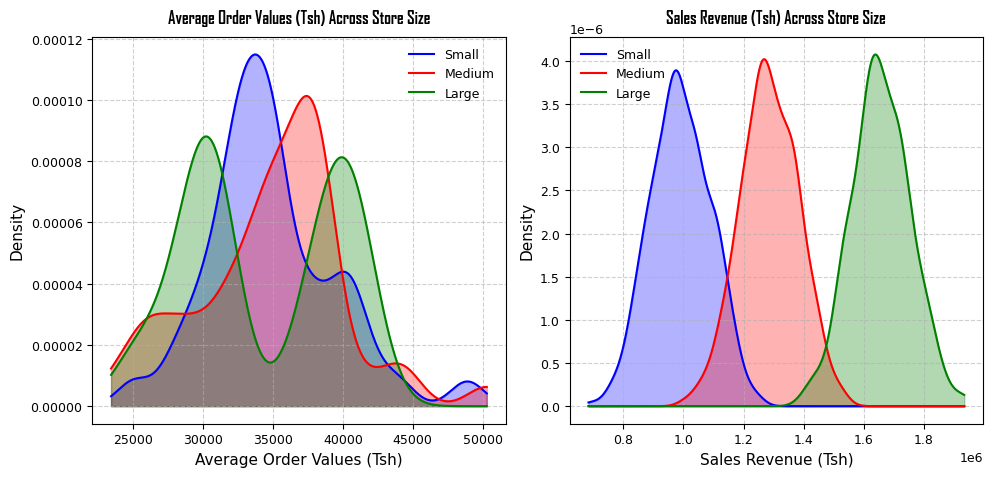

In [196]:
Variables = numerical_columns = ["Average Order Values (Tsh)", "Sales Revenue (Tsh)"]
kdeplots = multiple_kdeplots(df, Variables, group_col='Store Size')

<h4 style='font-family: Agency FB; font-size: 18px; font-weight: 600'>5.3:  Barplot | Visual Comparisons</h4> 

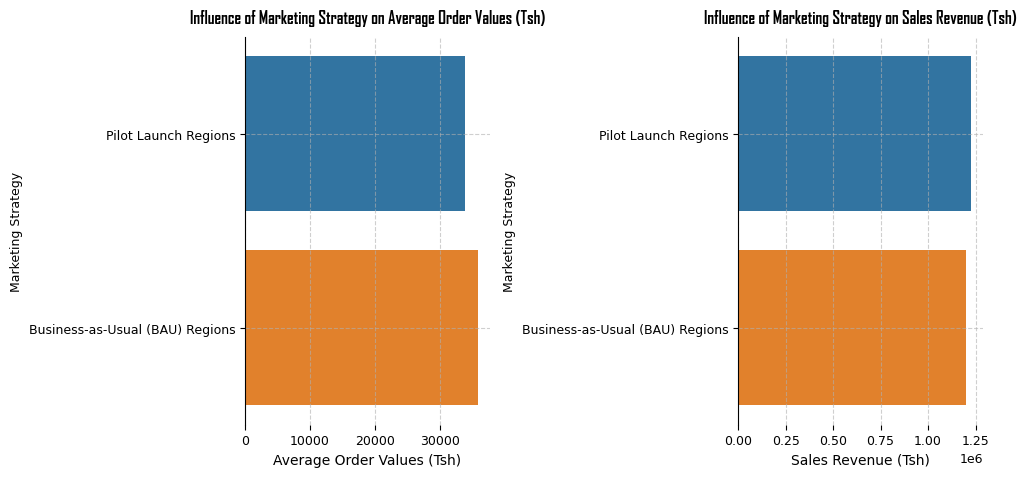

In [197]:
def multiple_barplots(df, Variables, group_col):
    num_variables = len(Variables)
    rows = math.ceil(num_variables / 3)
    cols = min(num_variables, 2)
    
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
    axes = axes.flatten() if num_variables > 1 else [axes]
    
    for idx, column in enumerate(Variables):
        sns.barplot(data=df, x=df[column], y=df[group_col], ax=axes[idx], hue =group_col, linewidth=0.6, errorbar=None)   
        sns.despine(ax=axes[idx], right=True, bottom=True)
        axes[idx].set_title(f"Influence of {group_col} on {column}", fontsize=12, pad=10, fontweight='bold', fontfamily='Agency FB')
        axes[idx].set_xlabel(column, fontsize=10)
        axes[idx].grid(linestyle='--', alpha=0.6)
        
    
    for idx in range(num_variables, len(axes)):
        fig.delaxes(axes[idx])
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
    return fig
    
Variables = numerical_columns = ["Average Order Values (Tsh)", "Sales Revenue (Tsh)"]
barplots = multiple_barplots(df, Variables, group_col='Marketing Strategy')

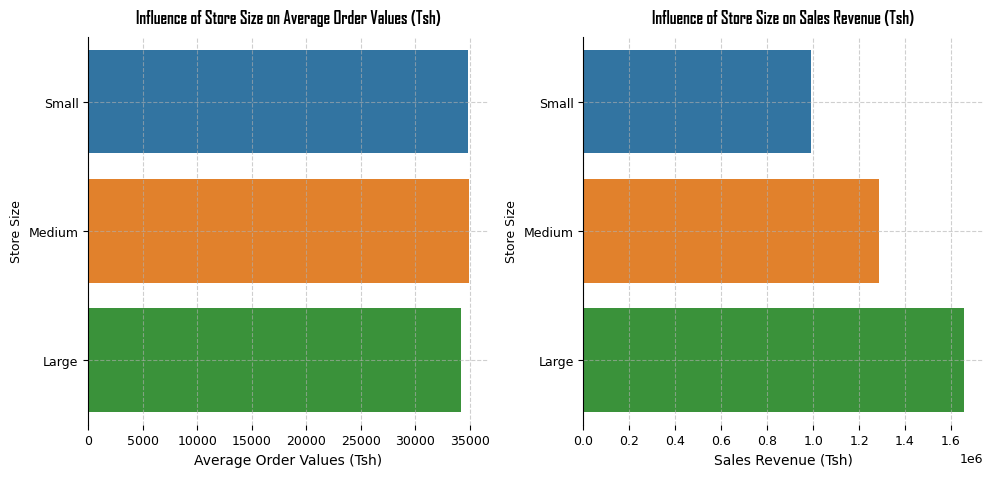

In [198]:
Variables = numerical_columns = ["Average Order Values (Tsh)", "Sales Revenue (Tsh)"]
barplots = multiple_barplots(df, Variables, group_col='Store Size')

<h4 style='font-family: Agency FB; font-size: 18px; font-weight: 600'>5.4:  Boxplot | Visual Comparisons</h4> 

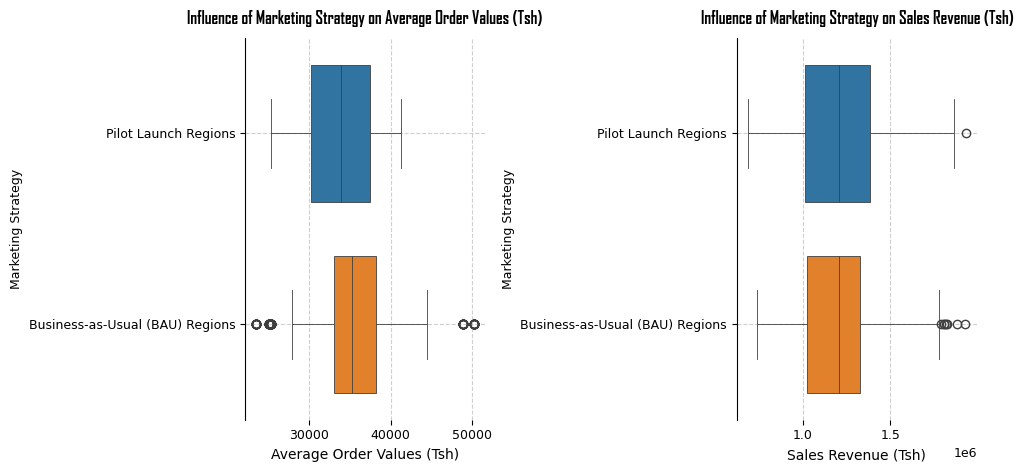

In [199]:
def multiple_boxplots(df, Variables, group_col):
    num_variables = len(Variables)
    rows = math.ceil(num_variables / 3)
    cols = min(num_variables, 2)
    
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
    plt.rcParams.update({'font.family': 'Dubai', 'font.style': 'normal', 'font.size': 11 })
    axes = axes.flatten() if num_variables > 1 else [axes]
    
    for idx, column in enumerate(Variables):
        sns.boxplot(data=df, x=df[column], y=df[group_col], fill=True, gap=0.1, ax=axes[idx], hue =group_col, linewidth=0.6)   
        sns.despine(ax=axes[idx], right=True, bottom=True)
        axes[idx].set_title(f"Influence of {group_col} on {column}", fontsize=12, pad=10, fontweight='bold', fontfamily='Agency FB')
        axes[idx].set_xlabel(column, fontsize=10)
        axes[idx].grid(linestyle='--', alpha=0.6)
        
    for idx in range(num_variables, len(axes)): fig.delaxes(axes[idx])
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
    return fig

Variables = numerical_columns = ["Average Order Values (Tsh)", "Sales Revenue (Tsh)"]
boxplots = multiple_boxplots(df, Variables, group_col='Marketing Strategy')

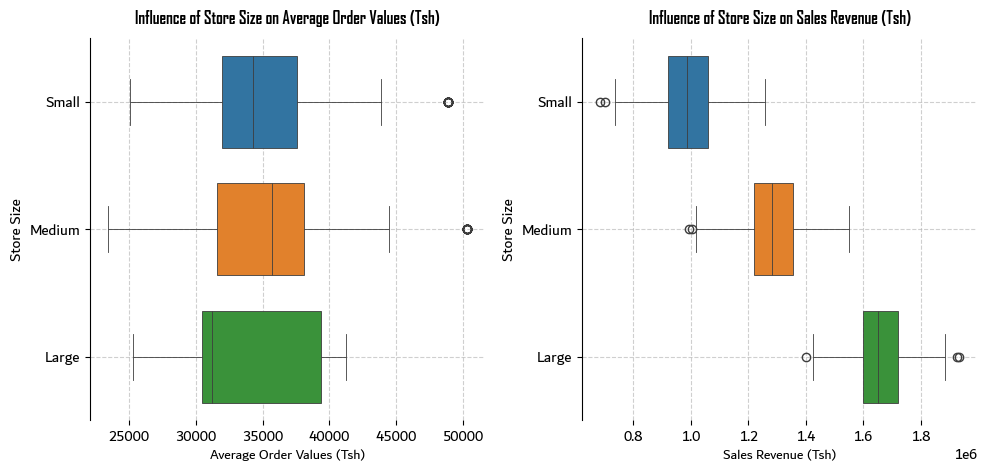

In [200]:
Variables = numerical_columns = ["Average Order Values (Tsh)", "Sales Revenue (Tsh)"]
boxplots = multiple_boxplots(df, Variables, group_col='Store Size')

<h3 style='font-size: 18px; color: blue; font-family: Agency FB; font-weight: 600'>5.5: Relationship Between Variables (Scatterplot Matrix)</h3>

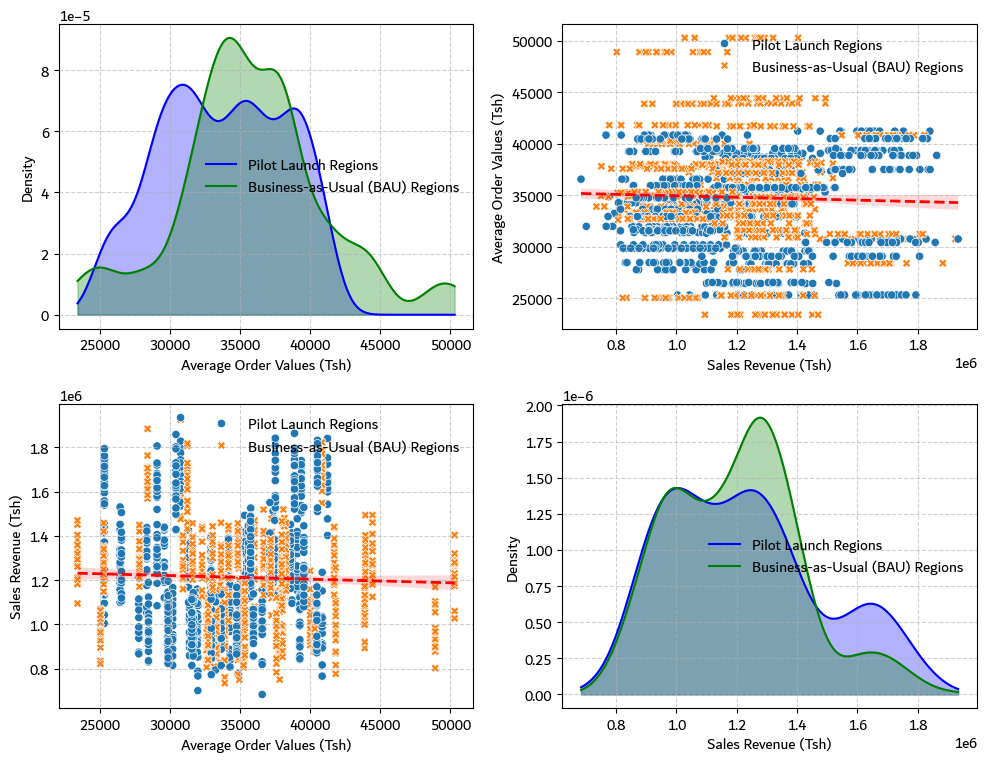

In [201]:
def scatterplot_matrix(data, Variables, group_col):
    num_variables = len(Variables)
    rows = num_variables 
    cols = num_variables
    
    fig, axes = plt.subplots(rows, cols, figsize=(10,8))
    
    for i in range(num_variables):
        for j in range(num_variables):
            ax = axes[i, j]
            if i == j:
                categories = df[group_col].unique()
                colors = ['blue', 'green', 'red']
                x_range = np.linspace(df[Variables[j]].min(), df[Variables[j]].max(), 1000)
                for sp, color in zip(categories, colors):
                    data = df[df[group_col] == sp][Variables[j]]
                    kde = gaussian_kde(data)
                    ax.plot(x_range, kde(x_range), label=sp, color=color)
                    ax.fill_between(x_range, kde(x_range), alpha=0.3, color=color)
                ax.set_xlabel(Variables[j], fontsize=11)
                ax.set_ylabel('Density', fontsize=11)
                ax.grid(linestyle='--', alpha=0.6)
                ax.legend(frameon=False)
            else:
                sns.scatterplot(data=df, x=df[Variables[j]], y=df[Variables[i]], ax=ax, hue=group_col, style=group_col, alpha=1)
                sns.regplot(data=df, x=df[Variables[j]], y=df[Variables[i]], ax=ax,  scatter=False, line_kws={'color': 'red', 'linestyle': '--', 'lw': 2})
                
                ax.set_xlabel(Variables[j], fontsize=11)
                ax.set_ylabel(Variables[i], fontsize=11)
                ax.grid(linestyle='--', alpha=0.6)
                ax.legend(frameon=False)
                
    
    for i in range(num_variables):
        for j in range(num_variables):
            if i == j:
                axes[i, j].axis('on') 
    
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

Variables = ["Average Order Values (Tsh)", "Sales Revenue (Tsh)"]
scatterplot_matrix(df, Variables, group_col='Marketing Strategy')

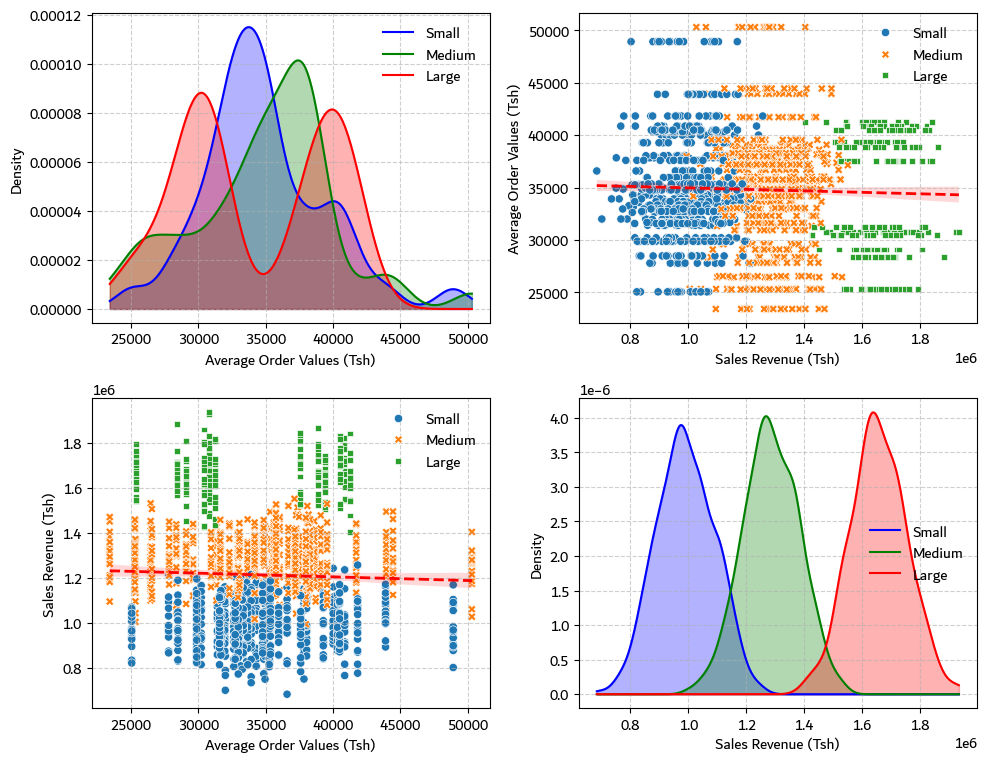

In [202]:
Variables = ["Average Order Values (Tsh)", "Sales Revenue (Tsh)"]
scatterplot_matrix(df, Variables, group_col='Store Size')

<h3 style='font-size: 18px; color: purple; font-family: Agency FB; font-weight: 600'>5.6: Trend Visualization</h3>

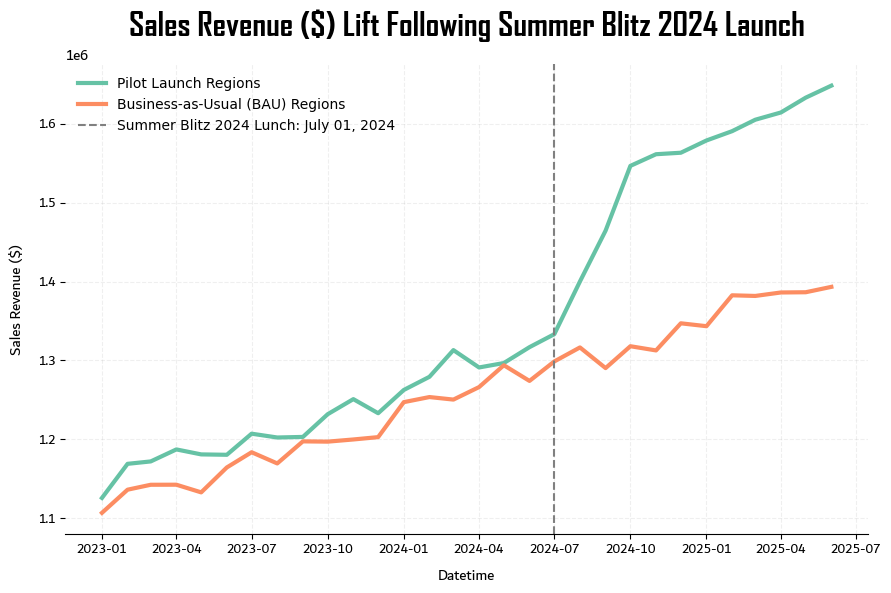

In [203]:
def visulize_lineplot(df, date_col, value_col, group_col, event_date, title, xlabel, ylabel, label, figsize = (9, 6)):
    fig, ax = plt.subplots(figsize=figsize)
    
    plt.rcParams.update({'font.family': 'Sans-Serif', 'font.style': 'normal', 'font.size': 9})
    sns.lineplot(data=df, x=date_col, y=value_col, hue=group_col, palette='Set2', alpha=1, errorbar=None, linewidth=3)
    plt.axvline(event_date, color='gray', linestyle='--', label=f'{label}: {event_date.strftime('%B %d, %Y')}')
    plt.title(title, fontweight='bold', fontsize=24, pad=20, fontfamily='Agency FB')
    sns.despine(ax=ax, left=True, right=True, bottom=False)
    plt.grid(linestyle='--', alpha=0.2) 
    
    plt.xlabel(xlabel, fontsize=11, labelpad=10)
    plt.ylabel(ylabel, fontsize=11, labelpad=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(frameon=False, fontsize=10)
    
    plt.tight_layout()
    plt.show()

df['Date'] = pd.to_datetime(df['Date'])
event_date = df['Date'].min() + pd.DateOffset(months=18)
title = "Sales Revenue ($) Lift Following Summer Blitz 2024 Launch"
visulize_lineplot(
    df = full_data, 
    date_col = 'Date', 
    value_col = 'Sales Revenue (Tsh)', 
    group_col = 'Marketing Strategy', 
    event_date = event_date, 
    title = title, 
    xlabel = 'Datetime',
    ylabel = 'Sales Revenue ($)',
    label = 'Summer Blitz 2024 Lunch'
)

<h1 style='font-family: Agency FB; font-size: 25px; font-weight: 600'>7.0: Parametictic Test Assumption Validation</h1>

<h3 style='font-family: Agency FB; font-size: 20px; font-weight: 600'>7.1: Homogeneity of Variance (Levene's Test)</h3>

In [204]:
def Levene_test(df, variables=None, groups=None): 
    if variables is None:
        variables = df.select_dtypes(include=['number']).columns.tolist()
        for g in groups:
            if g in variables:
                variables.remove(g)
    
    results = []
    for group in groups:
        for variable in variables:
            grouped_data = [g[variable].dropna().values for _, g in df.groupby(group)]
            if all(len(g) > 1 for g in grouped_data):  # Ensure each group has enough data
                levene_stat, levene_p = levene(*grouped_data)
                interpretation = 'Homogeneous' if levene_p > 0.05 else 'Not Homogeneous'
                
            else:
                levene_stat, levene_p, interpretation = None, None, 'Insufficient data'
            
            results.append({
                'Category': group,
                'Variable': variable,
                'Test Statistic': levene_stat,
                'P-Value': levene_p,
                'Interpretation': interpretation
            })
    
    return pd.DataFrame(results)
variables = ["Average Order Values (Tsh)", "Sales Revenue (Tsh)"]
result_df = Levene_test(df, variables, groups=["Store Size", "Marketing Strategy"])
display(result_df)

,Category,Variable,Test Statistic,P-Value,Interpretation
0,Store Size,Average Order Values (Tsh),19.74,0.00,Not Homogeneous
1,Store Size,Sales Revenue (Tsh),0.56,0.57,Homogeneous
2,Marketing Strategy,Average Order Values (Tsh),2.34,0.13,Homogeneous
3,Marketing Strategy,Sales Revenue (Tsh),32.72,0.00,Not Homogeneous


<h1 style='font-family: Agency FB; font-size: 25px; font-weight: 600'>8.0: Hypothesis Testing</h1>

<h3 style='font-family: Agency FB; font-size: 20px; font-weight: 600'>8.1: One Way  Analysis of Varience</h3>

In [205]:
from statsmodels.formula.api import ols as smf_ols 
from statsmodels.stats.anova import anova_lm  
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf 
import statsmodels.api as sm  

def rename(text): return re.sub(r'[^a-zA-Z]', "_", text)

def One_way_anova(data, dependent_ariables, Independents_variables):
    results = []
    Independents_variables = [rename(col) for col in Independents_variables]
    data = data.rename(columns={col: rename(col) for col in data.columns})
    for Independents_variable in Independents_variables:
        for col in dependent_ariables:
            column_name = rename(col)  
            formula = f"{column_name} ~ C({Independents_variable})" 
            model = smf.ols(formula, data=data).fit()
            anova_table = sm.stats.anova_lm(model, typ=2)
            for source, row in anova_table.iterrows():
                p_value = row["PR(>F)"]
                interpretation = "Significant" if p_value < 0.05 else "No significant"
                if source == "Residual": interpretation = "-"
        
                results.append({
                    "Variable": col,
                    "Factor": Independents_variable.title(),
                    "Source": source,
                    "Sum Sq": row["sum_sq"],
                    "df": row["df"],
                    "F-Value": row["F"],
                    "p-Value": p_value,
                    "Interpretation": interpretation
                })

    return pd.DataFrame(results)

Independents_variables = ["Store Size", "Marketing Strategy"]
dependent_ariables = ["Average Order Values (Tsh)", "Sales Revenue (Tsh)"]
anova_results = One_way_anova(df, dependent_ariables, Independents_variables)
anova_results

,Variable,Factor,Source,Sum Sq,df,F-Value,p-Value,Interpretation
0,Average Order Values (Tsh),Store_Size,C(Store_Size),106487361.20,2.00,2.12,0.12,No significant
1,Average Order Values (Tsh),Store_Size,Residual,45090293944.48,1797.00,NaN,NaN,-
2,Sales Revenue (Tsh),Store_Size,C(Store_Size),86935849314370.72,2.00,4536.89,0.00,Significant
3,Sales Revenue (Tsh),Store_Size,Residual,17217039246938.81,1797.00,NaN,NaN,-
4,Average Order Values (Tsh),Marketing_Strategy,C(Marketing_Strategy),1920908954.88,1.00,79.81,0.00,Significant
5,Average Order Values (Tsh),Marketing_Strategy,Residual,43275872350.80,1798.00,NaN,NaN,-
6,Sales Revenue (Tsh),Marketing_Strategy,C(Marketing_Strategy),408612612824.55,1.00,7.08,0.01,Significant
7,Sales Revenue (Tsh),Marketing_Strategy,Residual,103744275948484.53,1798.00,NaN,NaN,-


<h2 style='font-family: Agency FB; font-size: 20px; font-weight: 600'>8.2: Model Residual Diagonistic</h2>

In [206]:
def shapiro_wilk_test(df, Variables, group_cols):
    df = df.rename(columns={col: rename(col) for col in df.columns})
    test_results = []
    for group in group_cols:
        for original_col in Variables:
            formula = f"{rename(original_col)} ~ C({rename(group)})"
            model = smf.ols(formula, data=df).fit()
            residuals = model.resid
    
            stat, p_value = shapiro(residuals)
            test_results.append({
                'Factors': group,
                'Variable': original_col,
                'Statistic': stat,
                'P-Value': p_value,
                'Normality': 'Normally Distributed' if p_value > 0.05 else 'Not Normally Distributed'
            })

    results_df = pd.DataFrame(test_results)
    return results_df

independents_variables = ["Store Size", "Marketing Strategy"]
dependent_variables = ["Average Order Values (Tsh)", "Sales Revenue (Tsh)"]
results = shapiro_wilk_test(
    df = df, 
    Variables = dependent_variables, 
    group_cols = independents_variables)
display(results)

,Factors,Variable,Statistic,P-Value,Normality
0,Store Size,Average Order Values (Tsh),0.99,0.00,Not Normally Distributed
1,Store Size,Sales Revenue (Tsh),1.00,0.12,Normally Distributed
2,Marketing Strategy,Average Order Values (Tsh),0.99,0.00,Not Normally Distributed
3,Marketing Strategy,Sales Revenue (Tsh),0.97,0.00,Not Normally Distributed


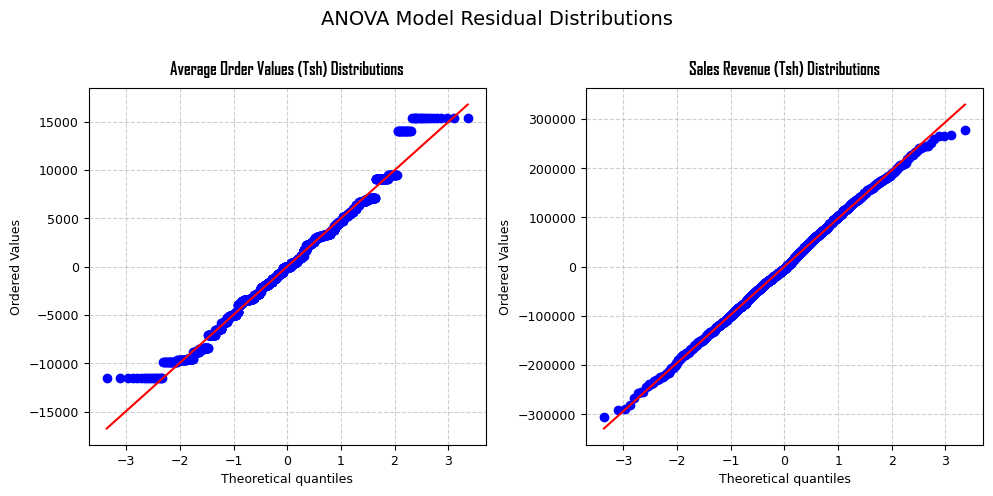

In [208]:
def multiple_qqplots(data, Variables, group_col):
    data = data.rename(columns={col: rename(col) for col in data.columns})
    
    num_variables = len(Variables)
    rows = math.ceil(num_variables / 3)
    cols = min(num_variables, 2)
    
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5* rows))
    fig.suptitle("ANOVA Model Residual Distributions", fontsize=14)
    axes = axes.flatten() if num_variables > 1 else [axes]
    
    for idx, column in enumerate(Variables):
        ax = axes[idx]
        formula = f"{rename(column)} ~ C({rename(group_col)})" 
        model = smf.ols(formula, data=data).fit()
        stats.probplot(model.resid, dist="norm", plot=ax)
        axes[idx].set_title(f"{column} Distributions", fontsize=12, pad=10, fontweight='bold', fontfamily='Agency FB')
        axes[idx].grid(linestyle='--', alpha=0.6)
    
    for idx in range(num_variables, len(axes)): fig.delaxes(axes[idx])
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
    return fig
    
Variables = ["Average Order Values (Tsh)", "Sales Revenue (Tsh)"]
qqplots = multiple_qqplots(df, Variables, group_col='Store Size')

<h2 style='font-size: 20px; font-family: Agency FB; font-weight: 600'>8.3: Welch's ANOVA (Welch's F test)</h2>

In [209]:
import pingouin as pg

def welchs_anova(data, dependent_variables, Independent_variables):
    results = []
    
    Independent_variables = [rename(col) for col in Independent_variables]
    data = data.rename(columns={col: rename(col) for col in data.columns})
    for group in Independent_variables:
        for col in dependent_variables:
            column_name = rename(col)
            
            aov = pg.welch_anova(data=data, dv=column_name, between=group)
            for _, row in aov.iterrows():
                p_value = row["p-unc"]
                interpretation = "Significant" if p_value < 0.05 else "Not Significant"
                results.append({
                    "Variable": col,
                    "Grouping Factor": group.title(),
                    "Source": row["Source"],
                    "df": row["ddof1"],
                    "F-Value": row["F"],
                    "p-Value": p_value,
                    "Significance": interpretation
                })

    return pd.DataFrame(results)

Independent_variables = ["Store Size", "Marketing Strategy"]
dependent_variables = ["Average Order Values (Tsh)", "Sales Revenue (Tsh)"]
welch_results = welchs_anova(df, dependent_variables, Independent_variables)
welch_results

,Variable,Grouping Factor,Source,df,F-Value,p-Value,Significance
0,Average Order Values (Tsh),Store_Size,Store_Size,2,1.85,0.16,Not Significant
1,Sales Revenue (Tsh),Store_Size,Store_Size,2,4558.85,0.00,Significant
2,Average Order Values (Tsh),Marketing_Strategy,Marketing_Strategy,1,79.81,0.00,Significant
3,Sales Revenue (Tsh),Marketing_Strategy,Marketing_Strategy,1,7.08,0.01,Significant


<h2 style='font-size: 20px; font-family: Agency FB; font-weight: 600'>8.4: Kruskal-Wallis Test</h2>

In [210]:
from scipy.stats import kruskal

def kruskall_wallis(df, independent_variables: str, dependent_variables: list = None):
    if dependent_variables is None:
        dependent_variables = df.select_dtypes(include=[np.number]).columns.tolist()
        for g in independent_variables:
            if g in dependent_variables:
                dependent_variables.remove(g)
    results = []
    for group_column in independent_variables:
        for column in dependent_variables:
            groups = [group[column].dropna().values for name, group in df.groupby(group_column)]
            stats, p_value = kruskal(*groups)
            interpretation = 'Significant' if p_value < 0.05 else 'Not Significant'
            results.append({
                'Group': group_column,
                'Variables': column,
                'Kruskal-Wallis Statistic': stats,
                'P-value': p_value,
                'Significant (α<0.05)': interpretation
            })
    return pd.DataFrame(results)

independent_variables = ["Store Size", "Marketing Strategy"] 
dependent_variables = ["Average Order Values (Tsh)", "Sales Revenue (Tsh)"]
results = kruskall_wallis(df, independent_variables, dependent_variables)
display(results)

,Group,Variables,Kruskal-Wallis Statistic,P-value,Significant (α<0.05)
0,Store Size,Average Order Values (Tsh),4.39,0.11,Not Significant
1,Store Size,Sales Revenue (Tsh),1437.47,0.00,Significant
2,Marketing Strategy,Average Order Values (Tsh),60.65,0.00,Significant
3,Marketing Strategy,Sales Revenue (Tsh),1.95,0.16,Not Significant


<h1 style='font-family: Agency FB; font-size: 25px; font-weight: 600'>9.0: Post-Hoc Analysis</h1>

<h2 style='font-family: Agency FB; font-size: 20px; font-weight: 600'>9.1: Tukey's Honest Significant Difference (THSD)</h2>


In [211]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd  

def Turkey_results(df, variables, group_cols):
    results_data = []
    for group in group_cols:
        for metric in variables:
            turkey_results = pairwise_tukeyhsd(endog=df[metric], groups=df[group], alpha=0.05)
            results_table = turkey_results.summary()
            
            for i in range(1, len(results_table)):
                row = results_table.data[i]
                results_data.append({
                    'group': group,
                    'Metric': metric,
                    'Group1': row[0],
                    'Group2': row[1],
                    'Mean Difference': row[2],
                    'P-Value': row[3],
                    'Lower CI': row[4],
                    'Upper CI': row[5],
                    'Reject Null': row[6]
                })
        
        result_df = pd.DataFrame(results_data)
    return result_df

group_cols = ["Store Size", "Marketing Strategy"] 
variables = ["Average Order Values (Tsh)", "Sales Revenue (Tsh)"]
results = Turkey_results(df, variables, group_cols = group_cols)
results

,group,Metric,Group1,Group2,Mean Difference,P-Value,Lower CI,Upper CI,Reject Null
0,Store Size,Average Order Values (Tsh),Large,Medium,742.21,0.11,-127.69,1612.11,False
1,Store Size,Average Order Values (Tsh),Large,Small,695.92,0.15,-185.59,1577.43,False
2,Store Size,Average Order Values (Tsh),Medium,Small,-46.28,0.98,-641.10,548.53,False
3,Store Size,Sales Revenue (Tsh),Large,Medium,-371103.76,0.00,-388102.13,-354105.40,True
4,Store Size,Sales Revenue (Tsh),Large,Small,-666105.63,0.00,-683330.86,-648880.40,True
5,Store Size,Sales Revenue (Tsh),Medium,Small,-295001.87,0.00,-306624.93,-283378.80,True
6,Marketing Strategy,Average Order Values (Tsh),Business-as-Usual (BAU) Regions,Pilot Launch Regions,-2066.08,0.00,-2519.67,-1612.49,True
7,Marketing Strategy,Sales Revenue (Tsh),Business-as-Usual (BAU) Regions,Pilot Launch Regions,30133.50,0.01,7924.89,52342.12,True


<h2 style='font-family: Agency FB; font-size: 20px; font-weight: 600'>9.2: Tukey's Honest Significant Difference (THSD) Results Visualization</h2>


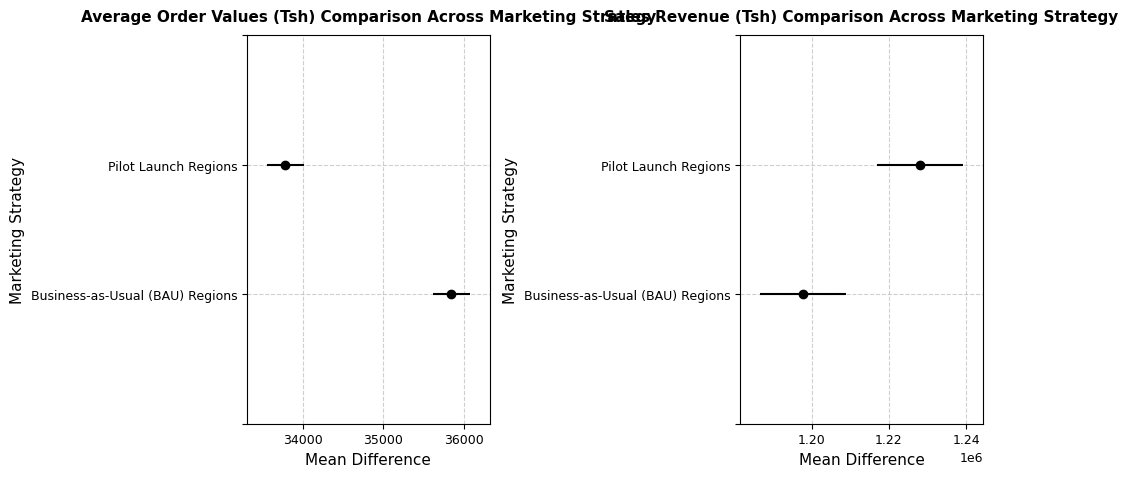

In [212]:
def Tukey_hsd_results_visualization(df, Variables, group):
    num_Variables = len(Variables)
    rows = math.ceil(num_Variables / 2)
    cols = min(num_Variables, 2)

    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
    axes = axes.flatten() if num_Variables > 1 else [axes]

    for idx, column in enumerate(Variables):
        tukey_result = pairwise_tukeyhsd(df[column], df[group], alpha=0.05)
        tukey_result.plot_simultaneous(figsize=(10,5), ax=axes[idx])
    
        axes[idx].set_title(f"{column} Comparison Across {group}", fontsize=11, pad=10, fontweight='bold')
        axes[idx].set_xlabel("Mean Difference", fontsize=11)
        axes[idx].set_ylabel(group, fontsize=11)
        axes[idx].grid(linestyle="--", alpha=0.6)

    for idx in range(num_Variables, len(axes)): fig.delaxes(axes[idx])

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

Variables = ["Average Order Values (Tsh)", "Sales Revenue (Tsh)"]
Tukey_hsd_results_visualization(df, Variables, group='Marketing Strategy')

<h1 style='font-family: Agency FB; font-size: 25px; font-weight: 600'>10.0: Quantifying Relationships and Magnitudes of an The effects</h1>

Effect size calculation is crucial for understanding the practical significance of the results in a study. While statistical tests like t-tests and ANOVA tell us whether the results are statistically significant, effect size tells us how big or how meaningful that effect actually is. Let's break down the most common effect size measures and how we calculate them.

<h3 style='font-size: 20px;  font-family: Agency FB; font-weight: 600'>10.1: Partial Eta-squared (ηp²))</h3>

In [213]:
def partial_eta_squared(df, numerical_columns, groups):
    results = []
    groups = [rename(col) for col in groups]
    df = df.rename(columns={col: rename(col) for col in df.columns})
    
    for column in numerical_columns:
        for group in groups:
            formula = f'{rename(column)} ~ C({group})'
            model = ols(formula, data=df).fit()
            anova_results = anova_lm(model, typ=2)
            SS_group = anova_results['sum_sq'][f'C({group})']
            SS_error = anova_results['sum_sq']['Residual']
            partial_eta_squared = SS_group / (SS_group + SS_error)
            
            results.append({
                "Variables": column,
                "Factor": group,
                "Partial Eta-squared (ηp²)": partial_eta_squared
            })
    

    eta_squared_df = pd.DataFrame(results)
    
    def interpret_eta_squared(eta_squared):
        if eta_squared >= 0.14: return "Large effect size (≥ 14%)"
        elif eta_squared >= 0.06: return "Medium effect size (6% - 14%)"
        else: return "Small effect size (< 6%)"
    eta_squared_df['Interpretation'] = eta_squared_df['Partial Eta-squared (ηp²)'].apply(interpret_eta_squared)
    return eta_squared_df


group_cols = ["Store Size", "Marketing Strategy"]
variables = ["Average Order Values (Tsh)", "Sales Revenue (Tsh)"]
eta_squared_df = partial_eta_squared(df, variables, group_cols)
eta_squared_df

,Variables,Factor,Partial Eta-squared (ηp²),Interpretation
0,Average Order Values (Tsh),Store_Size,0.00,Small effect size (< 6%)
1,Average Order Values (Tsh),Marketing_Strategy,0.04,Small effect size (< 6%)
2,Sales Revenue (Tsh),Store_Size,0.83,Large effect size (≥ 14%)
3,Sales Revenue (Tsh),Marketing_Strategy,0.00,Small effect size (< 6%)


<h3 style='font-size: 20px; font-family: Agency FB; font-weight: 600'>10.2. Eta-squared (η²)</h3>


In [214]:
def calculate_eta_squared(aov_table):
    ss_between = aov_table["sum_sq"].iloc[0]
    ss_total = aov_table["sum_sq"].sum()
    return ss_between / ss_total

def perform_anova_and_calculate_eta(df, metrics, group):
    group = [rename(col) for col in group]
    df = df.rename(columns={col: rename(col) for col in df.columns})  # Rename all columns
    
    results = []
    for metric in metrics:
        safe_column_name = rename(metric)
        data = df.rename(columns={metric: safe_column_name})
        
        formula = f'{safe_column_name} ~ ' + ' + '.join([f'C({g})' for g in group])
        model = ols(formula, data=data).fit()
        aov_table = sm.stats.anova_lm(model, typ=2)
        
        eta_sq = calculate_eta_squared(aov_table)
        aov_table["Eta-squared (η²)"] = np.nan
        aov_table.loc[aov_table.index[0], "Eta-squared (η²)"] = eta_sq
        
        anova_df = aov_table.reset_index().rename(columns={"index": "Source"})
        anova_df.insert(0, "Metric", metric)
        results.append(anova_df)
    
    return pd.concat(results, ignore_index=True)

group_cols = ["Store Size", "Marketing Strategy"]
variables = ["Average Order Values (Tsh)", "Sales Revenue (Tsh)"]
results = perform_anova_and_calculate_eta(df, variables, group_cols)
results

,Metric,Source,sum_sq,df,F,PR(>F),Eta-squared (η²)
0,Average Order Values (Tsh),C(Store_Size),19359821.13,2.00,0.40,0.67,0.00
1,Average Order Values (Tsh),C(Marketing_Strategy),1833781414.82,1.00,76.14,0.00,NaN
2,Average Order Values (Tsh),Residual,43256512529.67,1796.00,NaN,NaN,NaN
3,Sales Revenue (Tsh),C(Store_Size),86527773155903.97,2.00,4513.22,0.00,0.83
4,Sales Revenue (Tsh),C(Marketing_Strategy),536454358.01,1.00,0.06,0.81,NaN
5,Sales Revenue (Tsh),Residual,17216502792580.79,1796.00,NaN,NaN,NaN


<h3 style='font-size: 20px; font-family: Agency FB; font-weight: 600'>10.3. Cohen's d</h3>

In [215]:
def cohens_d(group1, group2):
    mean1 = np.mean(group1)
    mean2 = np.mean(group2)
    std1 = np.std(group1, ddof=1)
    std2 = np.std(group2, ddof=1)
    pooled_std = np.sqrt(((std1 ** 2) + (std2 ** 2)) / 2)
    return (mean1 - mean2) / pooled_std

def interpret_cohens_d(d_value):
    if abs(d_value) < 0.2:
        interpretation = "Small effect size"
    elif 0.2 <= abs(d_value) < 0.5:
        interpretation = "Medium effect size"
    elif 0.5 <= abs(d_value) < 0.8:
        interpretation = "Large effect size"
    else:
        interpretation = "Very large effect size"
    return interpretation

def calculate_effect_sizes(df, groups, numerical_columns):
    effect_size_results = []
    for group in groups:
        for column in numerical_columns:
            group_values = df[group].unique()
            for i in range(len(group_values)):
                for j in range(i + 1, len(group_values)):
                    group1 = df[df[group] == group_values[i]][column]
                    group2 = df[df[group] == group_values[j]][column]
                    
                    d_value = cohens_d(group1, group2)
                    interpretation = interpret_cohens_d(d_value)
                    effect_size_results.append({
                        'Group': group,
                        'Variable': column,
                        'Pair': f'{group_values[i]} vs {group_values[j]}',
                        'Cohen\'s d': d_value,
                        'Interpretation': interpretation
                    
                    })

    results = pd.DataFrame(effect_size_results)
    return results

group_col = ["Store Size", "Marketing Strategy"]
variables = ["Average Order Values (Tsh)", "Sales Revenue (Tsh)"]
results = calculate_effect_sizes(df, group_col, variables)
results

,Group,Variable,Pair,Cohen's d,Interpretation
0,Store Size,Average Order Values (Tsh),Small vs Medium,-0.01,Small effect size
1,Store Size,Average Order Values (Tsh),Small vs Large,0.14,Small effect size
2,Store Size,Average Order Values (Tsh),Medium vs Large,0.14,Small effect size
3,Store Size,Sales Revenue (Tsh),Small vs Medium,-3.00,Very large effect size
4,Store Size,Sales Revenue (Tsh),Small vs Large,-6.81,Very large effect size
5,Store Size,Sales Revenue (Tsh),Medium vs Large,-3.84,Very large effect size
6,Marketing Strategy,Average Order Values (Tsh),Pilot Launch Regions vs Business-as-Usual (BAU...,-0.42,Medium effect size
7,Marketing Strategy,Sales Revenue (Tsh),Pilot Launch Regions vs Business-as-Usual (BAU...,0.13,Small effect size


<h3 style='font-size: 20px; font-family: Agency FB; font-weight: 600'>10.4: Regression Analysis</h3>

In [216]:
def regression_analysis(data, variables, groups):
    data = data.rename(columns={col: rename(col) for col in df.columns})
    
    results = []
    for group in groups:
        for variable in variables:
            formula = f"{rename(variable)} ~ {rename(group)}"
            model = ols(formula, data=data).fit()
            
            for index, row in model.summary2().tables[1].iterrows():
                baseline = model.params['Intercept']
                coef = (row['Coef.'] / baseline) * 100
                results.append({
                    'Category': group,
                    "Variable": variable,
                    "Factor": index,
                    "Coef.": row["Coef."],
                    "Std.Err.": row["Std.Err."],
                    "t": row["t"],
                    "p-value": row["P>|t|"].round(4),
                    "95% CI Lower": row["[0.025"],
                    "95% CI Upper": row["0.975]"],
                    "Percent Diff. (%)": coef
                    
                })
    
    return pd.DataFrame(results)

groups = ["Store Size", "Marketing Strategy"]
variables = ["Average Order Values (Tsh)", "Sales Revenue (Tsh)"]
results = regression_analysis(df, variables, groups)
results

,Category,Variable,Factor,Coef.,Std.Err.,t,p-value,95% CI Lower,95% CI Upper,Percent Diff. (%)
0,Store Size,Average Order Values (Tsh),Intercept,34185.08,327.46,104.39,0.00,33542.83,34827.32,100.00
1,Store Size,Average Order Values (Tsh),Store_Size[T.Medium],742.21,370.86,2.00,0.05,14.85,1469.56,2.17
2,Store Size,Average Order Values (Tsh),Store_Size[T.Small],695.92,375.81,1.85,0.06,-41.14,1432.99,2.04
3,Store Size,Sales Revenue (Tsh),Intercept,1656752.54,6398.78,258.92,0.00,1644202.70,1669302.37,100.00
4,Store Size,Sales Revenue (Tsh),Store_Size[T.Medium],-371103.76,7246.77,-51.21,0.00,-385316.74,-356890.79,-22.40
5,Store Size,Sales Revenue (Tsh),Store_Size[T.Small],-666105.63,7343.49,-90.71,0.00,-680508.30,-651702.96,-40.21
6,Marketing Strategy,Average Order Values (Tsh),Intercept,35844.86,163.53,219.19,0.00,35524.12,36165.60,100.00
7,Marketing Strategy,Average Order Values (Tsh),Marketing_Strategy[T.Pilot Launch Regions],-2066.08,231.27,-8.93,0.00,-2519.67,-1612.49,-5.76
8,Marketing Strategy,Sales Revenue (Tsh),Intercept,1197874.74,8006.93,149.60,0.00,1182170.88,1213578.61,100.00
9,Marketing Strategy,Sales Revenue (Tsh),Marketing_Strategy[T.Pilot Launch Regions],30133.50,11323.51,2.66,0.01,7924.89,52342.12,2.52


---

This analysis was performed by **Jabulente**, a passionate and dedicated data analyst with a strong commitment to using data to drive meaningful insights and solutions. For inquiries, collaborations, or further discussions, please feel free to reach out via.  

----

<div align="center">  
    
[![GitHub](https://img.shields.io/badge/GitHub-Jabulente-black?logo=github)](https://github.com/Jabulente)  [![LinkedIn](https://img.shields.io/badge/LinkedIn-Jabulente-blue?logo=linkedin)](https://linkedin.com/in/jabulente-208019349)  [![Email](https://img.shields.io/badge/Email-jabulente@hotmail.com-red?logo=gmail)](mailto:Jabulente@hotmail.com)  

</div>


<h1 style='font-size: 35px; color: red; font-family: Agency FB; font-weight: 700; text-align: center'>Data to Drive Meaningful Insights and Solutions</h1>